# Translate lidar setup from AMR-Wind to Nalu-Wind

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/ascldap/users/lcheung/wind_uq/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm
import yaml as yaml
from IPython.display import display, Markdown, Latex

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

Loader=yaml.safe_load

In [2]:
def convertNaluLidar(naludict, overridecenter=None, periodic=True):
    amrdict = {}
    amrdict['name'] = naludict['name'].replace('/','_')
    lidarspec       = naludict['scanning_lidar_specifications']
    
    sweep_angle           = lidarspec['sweep_angle']
    stare_time            = lidarspec['stare_time']
    step_delta_angle      = lidarspec['step_delta_angle']
    elevation_angles      = lidarspec['elevation_angles']
    T_per_ele             = stare_time*(sweep_angle/step_delta_angle)
    T_per_scan            = len(elevation_angles)*T_per_ele 
    # Get the lidar center angle
    axis                  = lidarspec['axis']
    sweep_center = np.arctan2(float(axis[1]), float(axis[0]))*180.0/np.pi  # Compute sweep_center from axis
    #print(sweep_center)
    azi1         = sweep_center - 0.5*sweep_angle
    azi2         = sweep_center + 0.5*sweep_angle
    
    amrdict['origin']     = lidarspec['center'] if overridecenter is None else overridecenter
    amrdict['length']     = lidarspec['beam_length']
    amrdict['num_points'] = naludict['points_along_line']
    amrdict['periodic']   = periodic
    t_between_azisweep    = 0.001
    
    t_table   = []
    azi_table = []
    ele_table = []
    
    if ('ground_direction') in lidarspec and lidarspec['ground_direction']==[1,0,0]:
        for dazi in elevation_angles:
            azi0    = sweep_center + dazi
            ele1    = -0.5*sweep_angle
            ele2    = +0.5*sweep_angle
            t_seg   = [0.0, T_per_scan]
            azi_seg = [azi0, azi0]
            ele_seg = [ele1, ele2]
            if len(t_table)>0:
                t0    = t_table[-1]
                t_seg = [t0+t+t_between_azisweep for t in t_seg]
            t_table = t_table + t_seg
            azi_table = azi_table + azi_seg
            ele_table = ele_table + ele_seg
    else:
        for ele in elevation_angles:
            t_seg   = [0.0, T_per_scan]
            azi_seg = [azi1, azi2]
            ele_seg = [ele, ele]
            if len(t_table)>0:
                t0    = t_table[-1]
                t_seg = [t0+t+t_between_azisweep for t in t_seg]
            t_table = t_table + t_seg
            azi_table = azi_table + azi_seg
            ele_table = ele_table + ele_seg
    
    # Convert to strings
    amrdict['time_table']      = ' '.join([repr(x) for x in t_table])
    amrdict['azimuth_table']   = ' '.join([repr(x) for x in azi_table])
    amrdict['elevation_table'] = ' '.join([repr(x) for x in ele_table])

    return amrdict

def plotLidarDict(axs, d, formatfunc=None):
    str2list = lambda l: [float(x) for x in l.split()] 
    time_table = str2list(d['time_table'])
    azimuth_table   = str2list(d['azimuth_table'])
    elevation_table = str2list(d['elevation_table'])
    axs[0].plot(time_table, azimuth_table)
    axs[1].plot(time_table, elevation_table)
    if formatfunc is not None:
        formatfunc(axs)
    return

def getTurbSubset(csvfile, suffix):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        if x[1]['# name'].endswith(suffix):
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

In [3]:
naluyaml="""
    - name: lidar/NREL1_WakeMeandHoriz  # Wake meandering (the PPI scan of an alternating PPI/RHI scan)
      from_target_part: &allparts 1
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP #[10050.588260, 8081.533244, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 0.7 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 3 #deg
        reset_time_delta: 4.9 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/NREL1_WakeMeandVert  # Wake meandering (the RHI scan of an alternating PPI/RHI scan)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP #[10050.588260, 8081.533244, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 0.7 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 3 #deg
        reset_time_delta: 4.9 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]
        ground_direction: [1,0,0] # turn the sweep direction vertical

    - name: lidar/NREL1_InflowStats  # Inflow statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP #[10050.588260, 8081.533244, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.1 #s
        sweep_angle: 40 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/NREL1_InflowTurb  # Inflow turbulence
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP  [10050.588260, 8081.533244, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.0 #s
        sweep_angle: 30 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/NREL1_Wake3DStats  # Wake statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP #[10050.588260, 8081.533244, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.1 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [-10,-8.5,-7,-5.5,-4,-2.5,-1.0,0.5,2.0,3.5,5.0,6.5,8.0,9.5]

    - name: lidar/NREL1_FarmStats_Up  #Farm statistics (upstream)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP #[10050.588260, 8081.533244, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.6 #s
        sweep_angle: 120 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 7.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [-10,-8,-6,-4,-2,0,2,4,6,8,10]

    - name: lidar/NREL2_InflowTurb  # Inflow turbulence
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642927.453405, 4030718.728327, 91.0] # on top of 2019-WTW-4657-OE [9927.453405, 13218.728327, 91.0]   # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.0 #s
        sweep_angle: 30 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/NREL2_WakeMeandHoriz  # Wake meandering (the PPI scan of an alternating PPI/RHI scan)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642927.453405, 4030718.728327, 91.0] # on top of 2019-WTW-4657-OE [9927.453405, 13218.728327, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 0.7 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 3 #deg
        reset_time_delta: 4.9 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/NREL2_WakeMeandVert  # Wake meandering (the RHI scan of an alternating PPI/RHI scan)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642927.453405, 4030718.728327, 91.0] # on top of 2019-WTW-4657-OE [9927.453405, 13218.728327, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 0.7 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 3 #deg
        reset_time_delta: 4.9 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]
        ground_direction: [1,0,0] # turn the sweep direction vertical

    - name: lidar/NREL2_InflowStats  # Inflow statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642927.453405, 4030718.728327, 91.0] # on top of 2019-WTW-4657-OE [9927.453405, 13218.728327, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.1 #s
        sweep_angle: 40 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/NREL2_Wake3DStats  # Wake statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642927.453405, 4030718.728327, 91.0] # on top of 2019-WTW-4657-OE [9927.453405, 13218.728327, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.1 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [-10,-8.5,-7,-5.5,-4,-2.5,-1.0,0.5,2.0,3.5,5.0,6.5,8.0,9.5]

    - name: lidar/NREL2_FarmStats_Dn  # Farm statistics (downstream)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642927.453405, 4030718.728327, 91.0] # on top of 2019-WTW-4657-OE [9927.453405, 13218.728327, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.6 #s
        sweep_angle: 120 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 7.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [-10,-8,-6,-4,-2,0,2,4,6,8,10]

    - name: lidar/EPFL2_InflowTurb  # Inflow turbulence
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642940.656099, 4028713.362363, 91] # On top of 2019-WTW-4697-KP [9940.656099, 11213.362363, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.0 #s
        sweep_angle: 30 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/EPFL2_InflowStats  # Inflow statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642940.656099, 4028713.362363, 91] # On top of 2019-WTW-4697-KP  [9940.656099, 11213.362363, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.1 #s
        sweep_angle: 40 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/EPFL3_WakeMeandHoriz  # Wake meandering (the PPI scan of an alternating PPI/RHI scan)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642940.656099, 4028713.362363, 91] # On top of 2019-WTW-4697-KP [9940.656099, 11213.362363, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 0.7 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 3 #deg
        reset_time_delta: 4.9 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/EPFL3_WakeMeandVert  # Wake meandering (the RHI scan of an alternating PPI/RHI scan)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642940.656099, 4028713.362363, 91] # On top of 2019-WTW-4697-KP [9940.656099, 11213.362363, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 0.7 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 3 #deg
        reset_time_delta: 4.9 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]
        ground_direction: [1,0,0] # turn the sweep direction vertical

    - name: lidar/EPFL3_Wake3DStats  # Wake statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642940.656099, 4028713.362363, 91] # On top of 2019-WTW-4697-KP [9940.656099, 11213.362363, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.1 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [-10,-8.5,-7,-5.5,-4,-2.5,-1.0,0.5,2.0,3.5,5.0,6.5,8.0,9.5]

    - name: lidar/NRELG_SpeedupStats  # Speedup statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [644600.601753, 4027108.285963, 91.0] # On top of 2019-WTW-4713-KP [11600.601753, 9608.285963, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.2 #s
        sweep_angle: 360 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 2.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]
"""

In [4]:
yamldict = Loader(naluyaml)

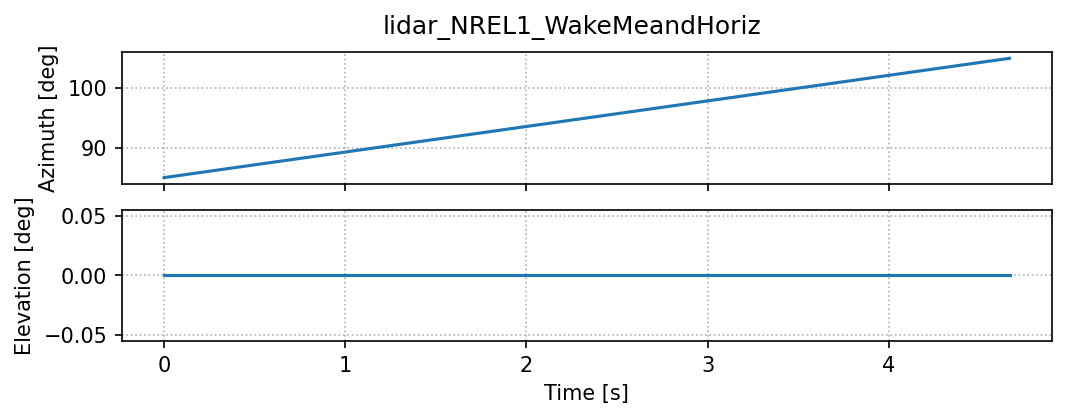

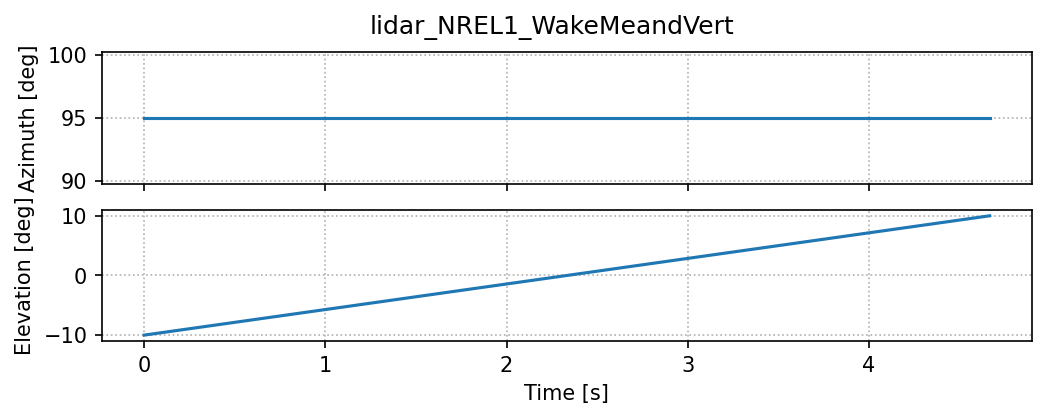

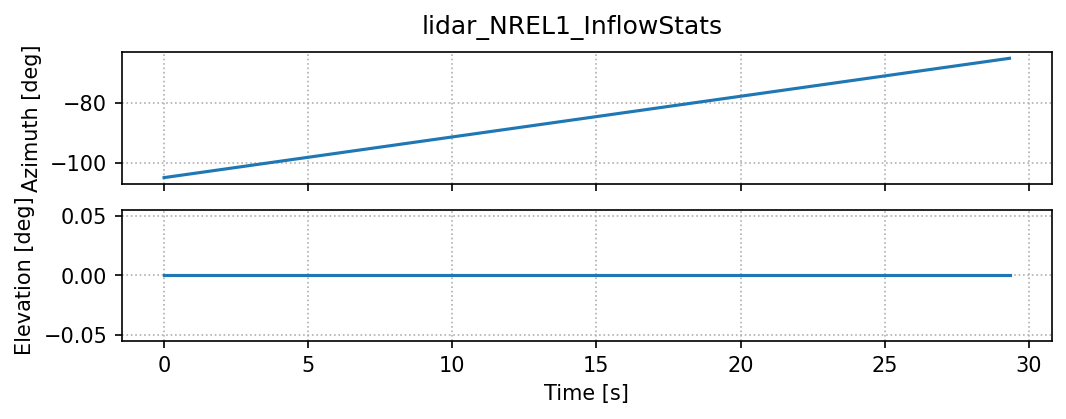

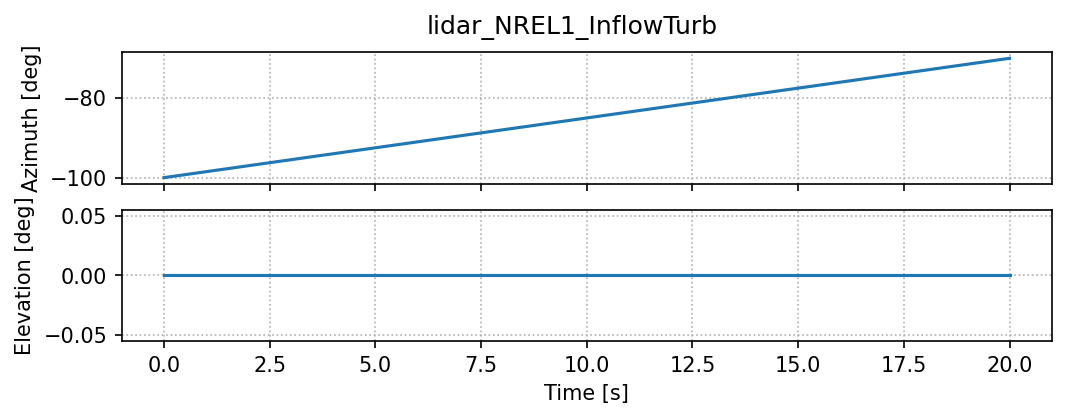

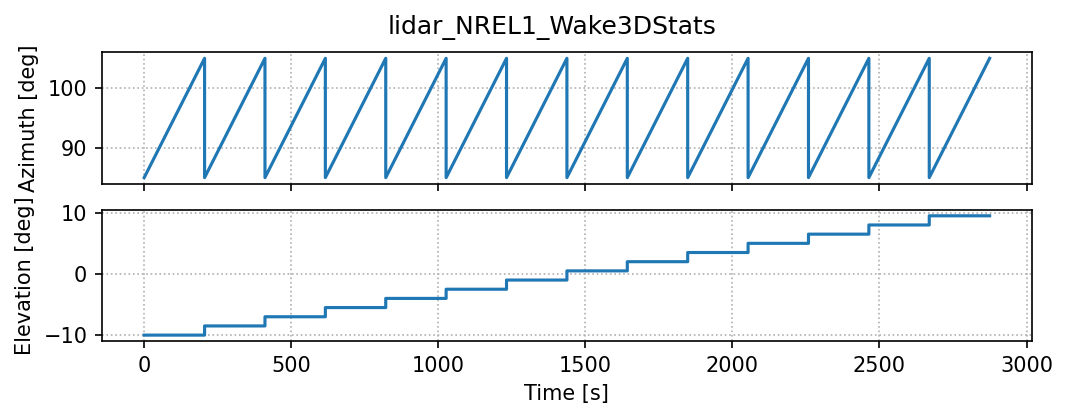

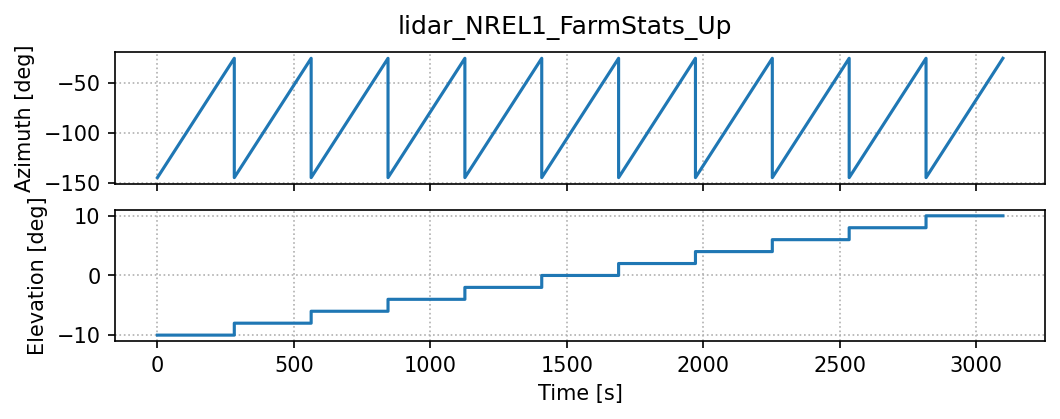

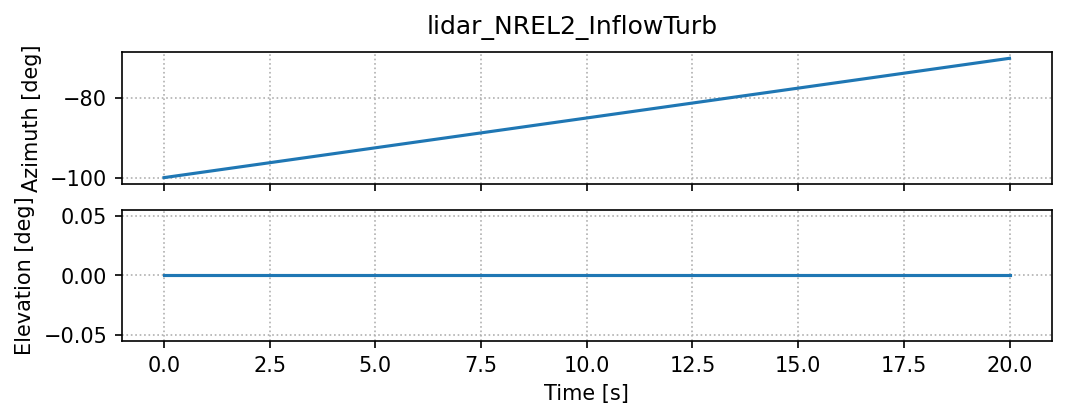

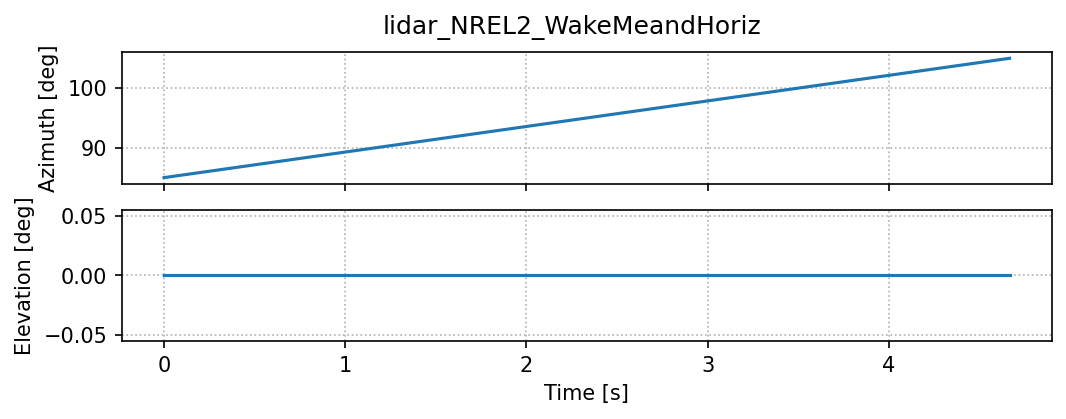

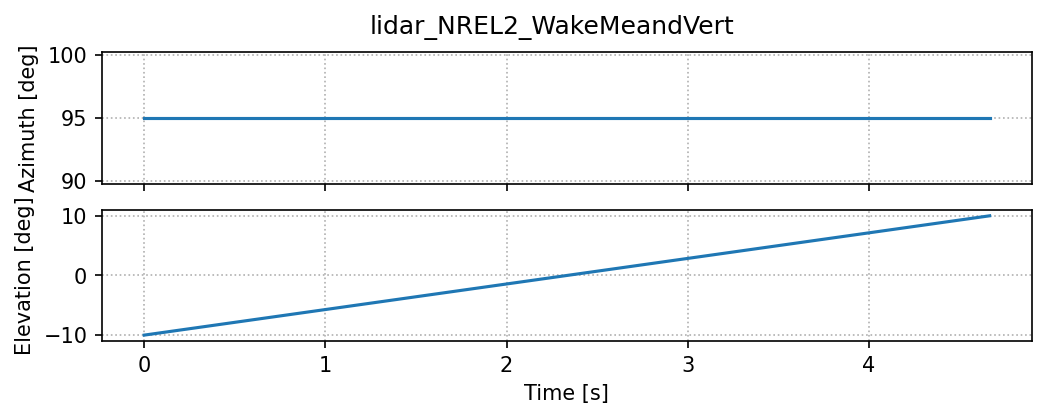

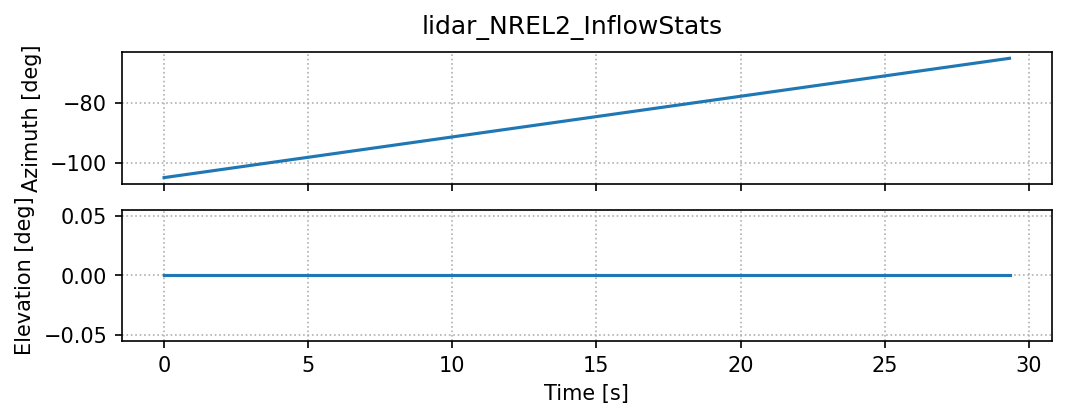

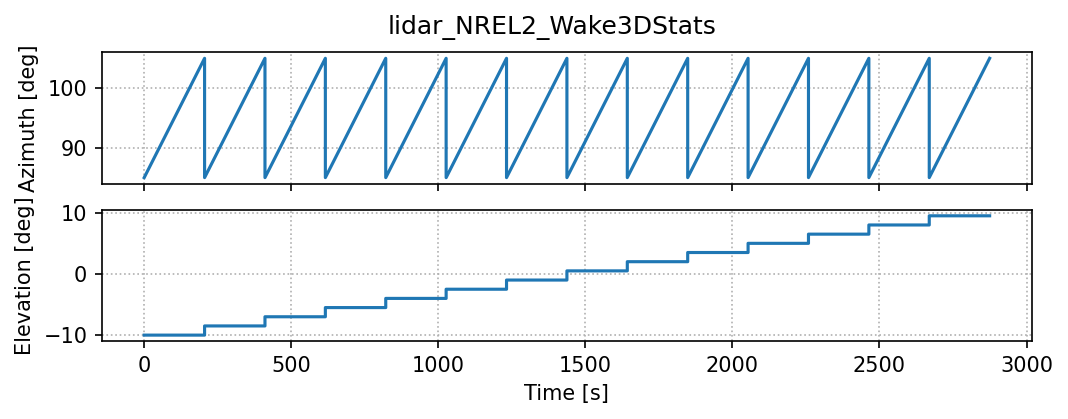

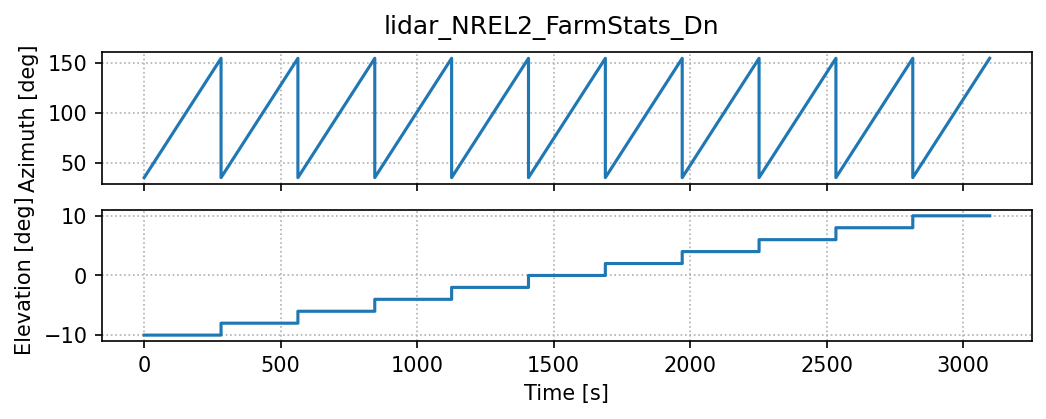

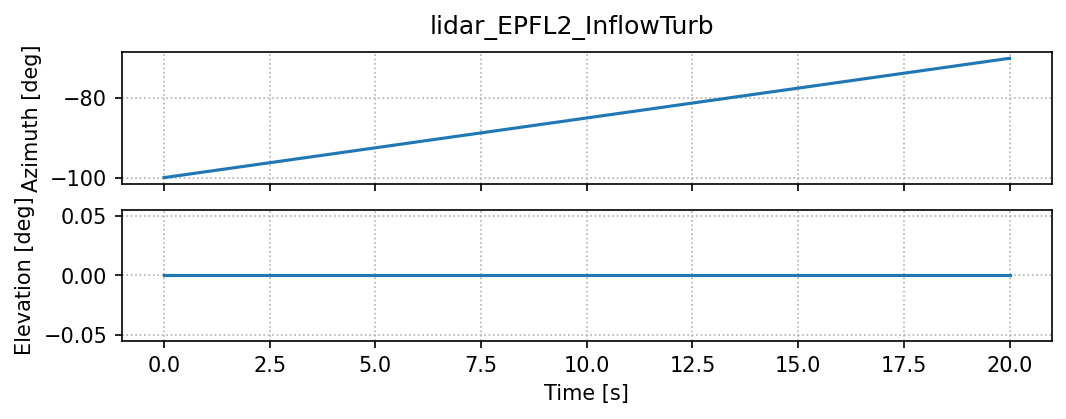

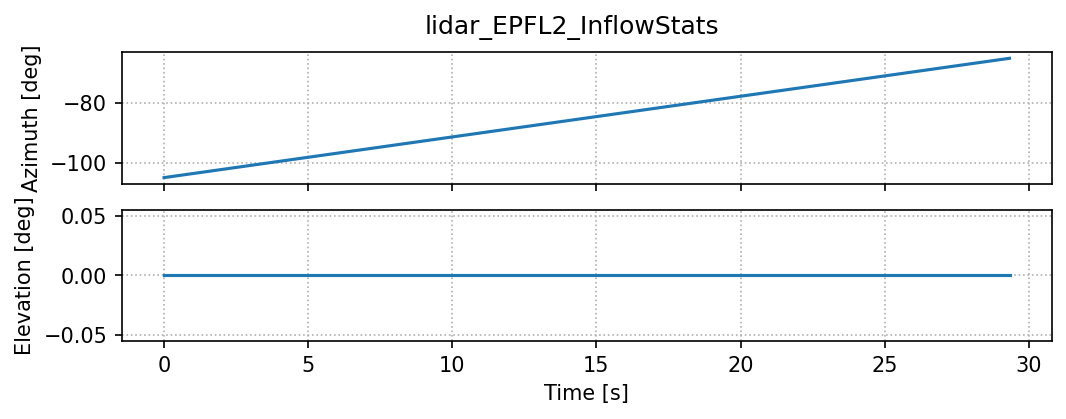

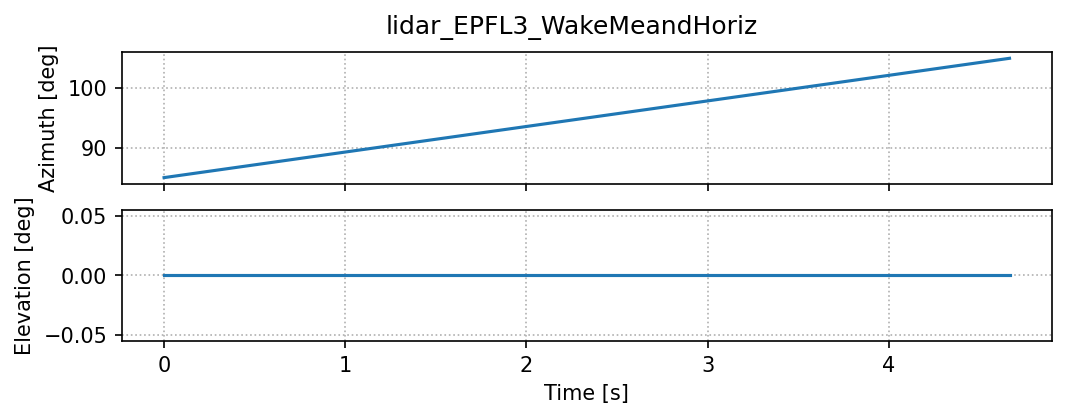

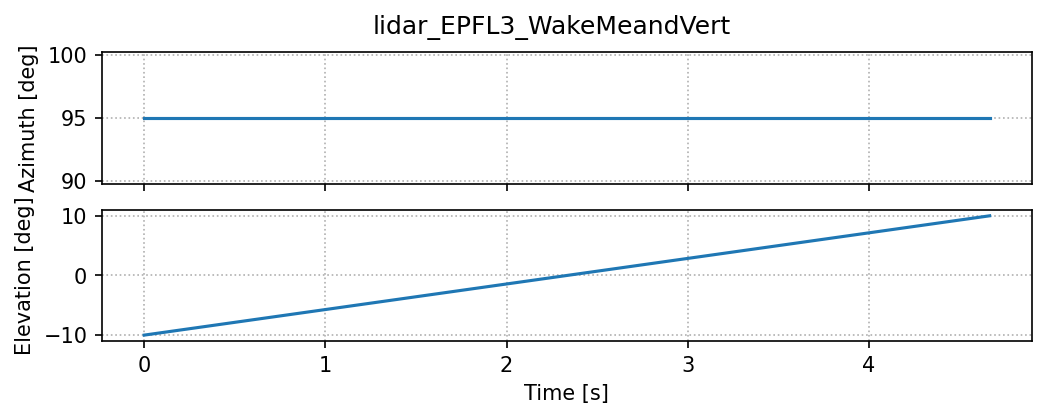

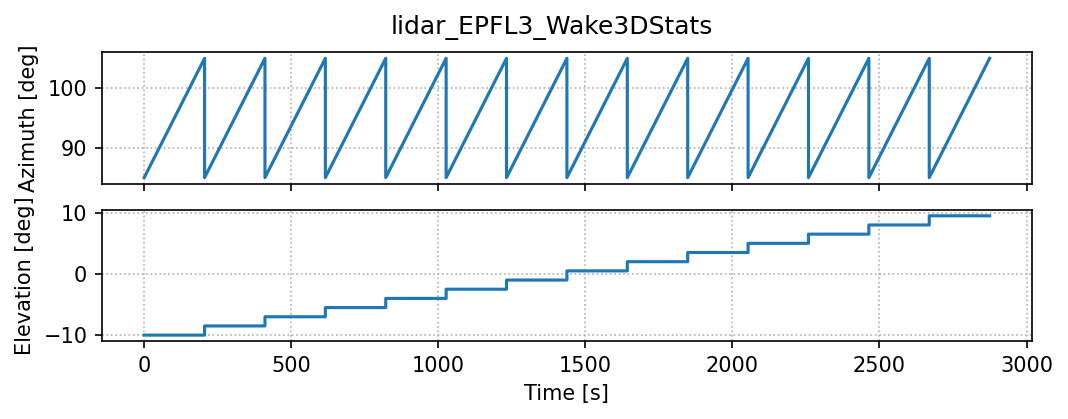

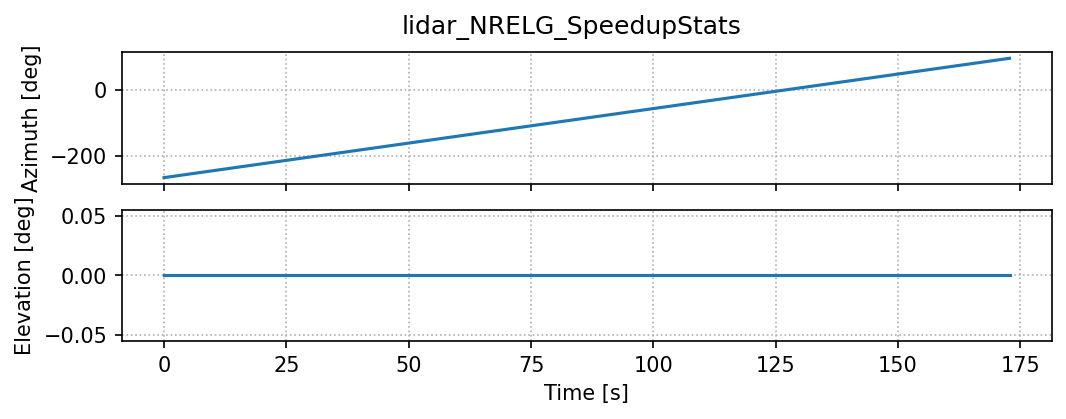

In [5]:
def formatfunc(axs):
    #axs[0].set_xlim([0, 3000])
    axs[0].grid(ls=':')
    axs[1].grid(ls=':')
    axs[1].set_xlabel('Time [s]')
    axs[0].set_ylabel('Azimuth [deg]')
    axs[1].set_ylabel('Elevation [deg]')
    return

for p in yamldict:
    fig, axs = plt.subplots(2,1, figsize=(8,2.5), dpi=150, sharex=True)
    amrp = convertNaluLidar(p)
    #print(amrp)
    plotLidarDict(axs, amrp, formatfunc=formatfunc)
    fig.suptitle(amrp['name'])


# Start the AMR-Wind domain plot

In [6]:
summitcsv    = 'UnstableABL_farmrun_turbines.csv'
KPturbdf = getTurbSubset(summitcsv, '-KP')

In [7]:
case = amrwind.MyApp.init_nogui()

In [8]:
case.setAMRWindInput('geometry.prob_lo',                         [588800.0, 3978800.0, 0.0])
case.setAMRWindInput('geometry.prob_hi',                         [691200.0, 4081200.0, 2560.0])
case.setAMRWindInput('amr.n_cell',                               [5120, 5120, 128])       # Number of cells in x, y, and z directions


In [9]:
# Set up averaging
lidarpprosetup = case.get_default_postprosetupdict()
lidarpprosetup['postprocessing_setup_name'] = 'lidar_'
lidarpprosetup['postprocessing_setup_type'] = 'Sampling'
lidarpprosetup['postprocessing_setup_output_frequency'] =  1
lidarpprosetup['postprocessing_setup_fields']           =  'velocity'
case.add_postprosetup(lidarpprosetup, verbose=True)

postprocessing_setup_name: 'lidar_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1
postprocessing_setup_fields: 'velocity'
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None


In [10]:
overridecenter = [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP
verbose = False
# Add metmast 
for lidar in yamldict:
    amrdict = convertNaluLidar(lidar)
    sampledict = case.get_default_samplingdict()
    sampledict['sampling_name']     = amrdict['name']
    del amrdict['name']
    sampledict['sampling_outputto'] = 'lidar_'
    sampledict['sampling_type']     = 'LidarSampler'
    #print(amrdict)
    for k, g in amrdict.items():
        sampledict['sampling_lidar_'+k] = g
    #sampledict['sampling_l_num_points'] = 50
    #sampledict['sampling_l_start']      = [site['utm'][0], site['utm'][1], 10]
    #sampledict['sampling_l_end']        = [site['utm'][0], site['utm'][1], 500]
    case.add_sampling(sampledict, verbose=verbose)
    if verbose: print('=================')

In [11]:
print(repr(case.listboxpopupwindict['listboxsampling'].getitemlist()))
print("Total: %i"%len(case.listboxpopupwindict['listboxsampling'].getitemlist()))

['lidar_NREL1_WakeMeandHoriz', 'lidar_NREL1_WakeMeandVert', 'lidar_NREL1_InflowStats', 'lidar_NREL1_InflowTurb', 'lidar_NREL1_Wake3DStats', 'lidar_NREL1_FarmStats_Up', 'lidar_NREL2_InflowTurb', 'lidar_NREL2_WakeMeandHoriz', 'lidar_NREL2_WakeMeandVert', 'lidar_NREL2_InflowStats', 'lidar_NREL2_Wake3DStats', 'lidar_NREL2_FarmStats_Dn', 'lidar_EPFL2_InflowTurb', 'lidar_EPFL2_InflowStats', 'lidar_EPFL3_WakeMeandHoriz', 'lidar_EPFL3_WakeMeandVert', 'lidar_EPFL3_Wake3DStats', 'lidar_NRELG_SpeedupStats']
Total: 18


Text(0.5, 0, 'UTM Northing [m]')

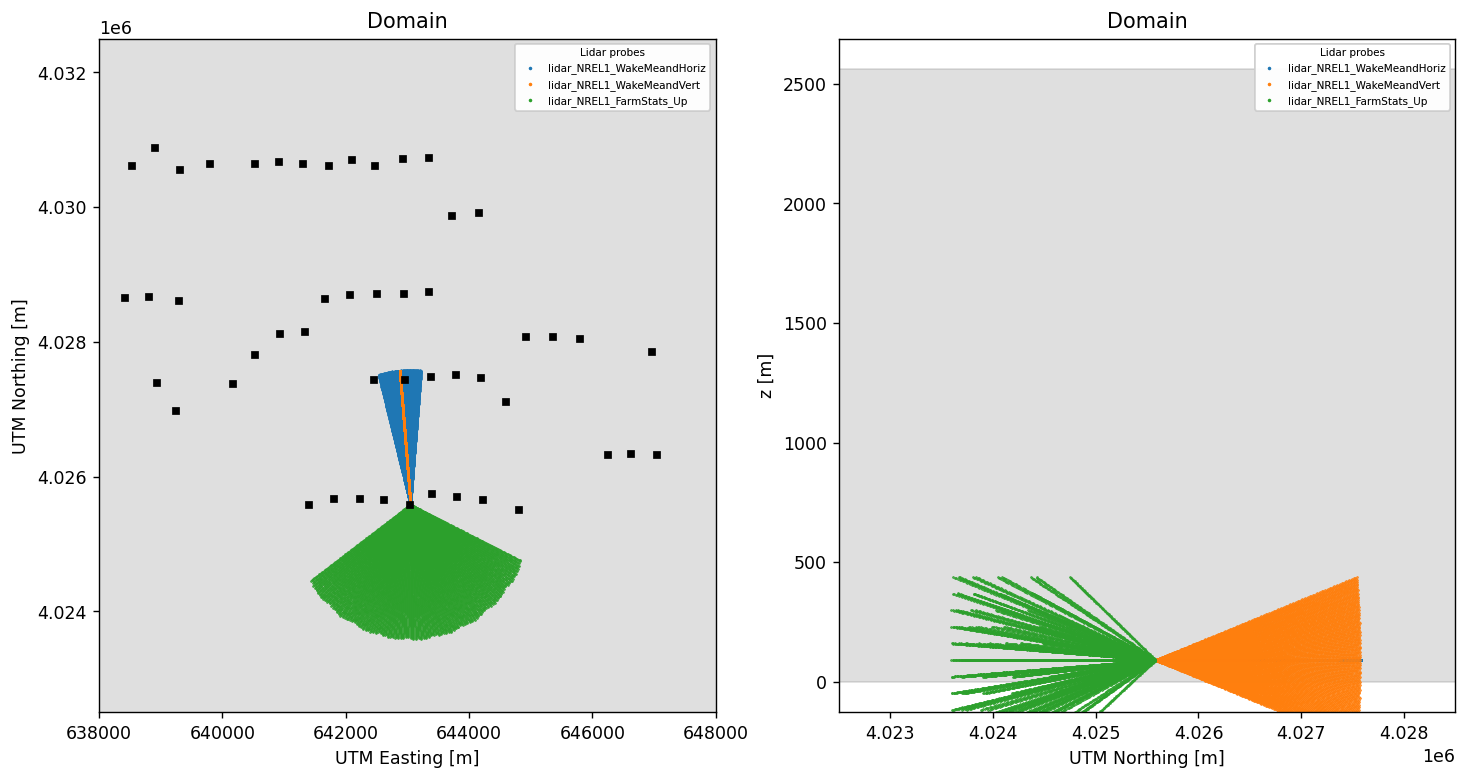

In [12]:
# Plot the domain
fig, axs = plt.subplots(1,2,figsize=(14,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':1, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Lidar probes', 'fontsize':6, 'loc':'upper right', 'markerscale':2}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['lidar_NREL1_WakeMeandHoriz', 'lidar_NREL1_WakeMeandVert', 'lidar_NREL1_FarmStats_Up'
                                                               ] #case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY' #'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] 
case.popup_storteddata['plotdomain']['plot_turbines']        = [] #case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False

ax = axs[0]
case.plotDomain(ax=ax, verbose=False, plotskip=5)

# Plot the turbines on top of it
for x in KPturbdf.iterrows():    
    ax.plot(float(x[1][' x']), float(x[1][' y']), 'ks', markersize=4)

ax.set_aspect('auto')
ax.set_xlim([638000,  648000])
ax.set_ylim([4022500, 4032500])
ax.set_xlabel('UTM Easting [m]')
ax.set_ylabel('UTM Northing [m]')

# Plot the side view
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
ax = axs[1]
case.plotDomain(ax=ax, verbose=False, plotskip=5)
ax.set_aspect('auto')
ax.set_xlim([4022500, 4028500])
ax.set_xlabel('UTM Northing [m]')

Text(0.5, 0, 'UTM Northing [m]')

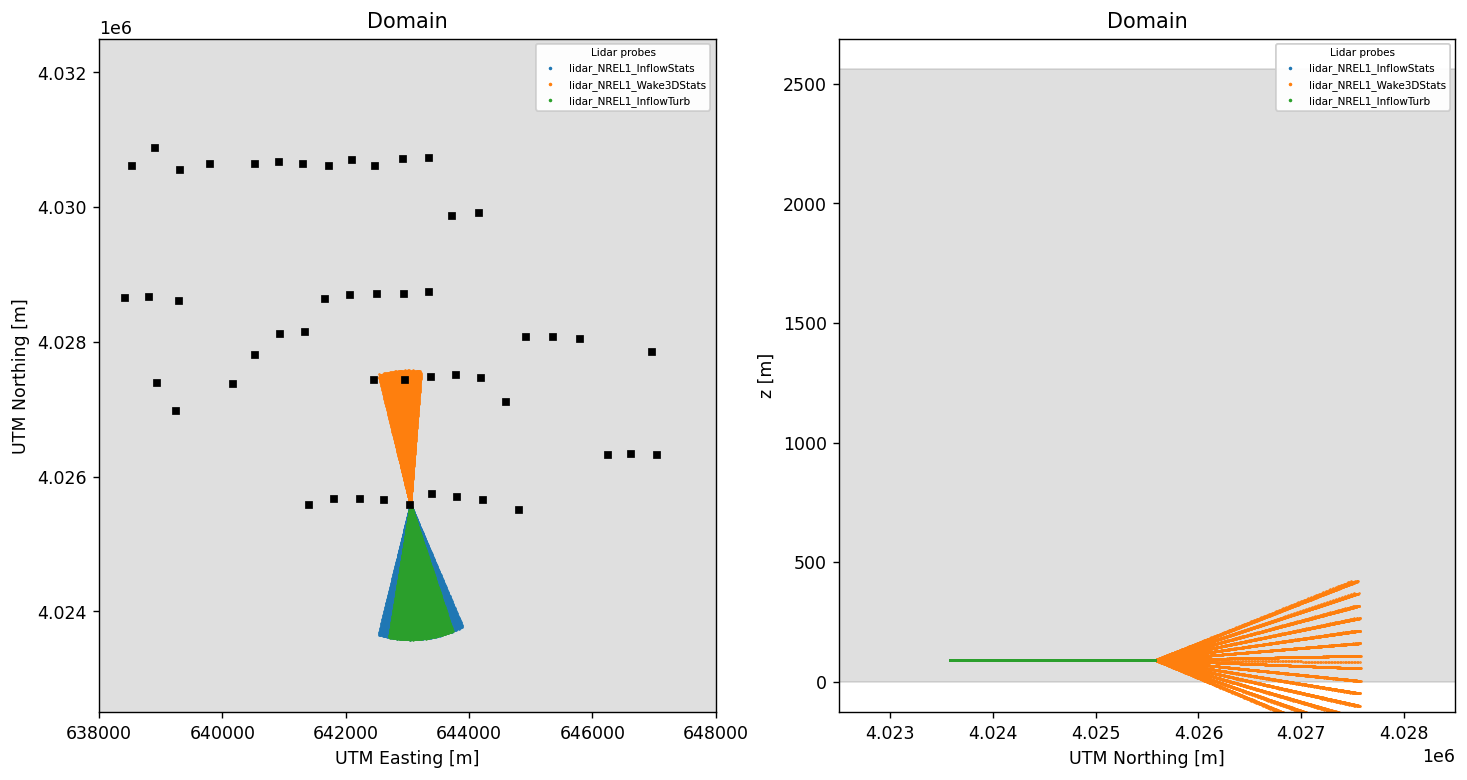

In [13]:
# Plot the domain
fig, axs = plt.subplots(1,2,figsize=(14,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':1, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Lidar probes', 'fontsize':6, 'loc':'upper right', 'markerscale':2}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['lidar_NREL1_InflowStats','lidar_NREL1_Wake3DStats', 'lidar_NREL1_InflowTurb',
                                                               ] #case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY' #'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] 
case.popup_storteddata['plotdomain']['plot_turbines']        = [] #case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False

ax = axs[0]
case.plotDomain(ax=ax, verbose=False, plotskip=5)

# Plot the turbines on top of it
for x in KPturbdf.iterrows():    
    ax.plot(float(x[1][' x']), float(x[1][' y']), 'ks', markersize=4)

ax.set_aspect('auto')
ax.set_xlim([638000,  648000])
ax.set_ylim([4022500, 4032500])
ax.set_xlabel('UTM Easting [m]')
ax.set_ylabel('UTM Northing [m]')

# Plot the side view
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
ax = axs[1]
case.plotDomain(ax=ax, verbose=False, plotskip=5)
ax.set_aspect('auto')
ax.set_xlim([4022500, 4028500])
ax.set_xlabel('UTM Northing [m]')

Text(0.5, 0.98, 'NREL2 lidar scans')

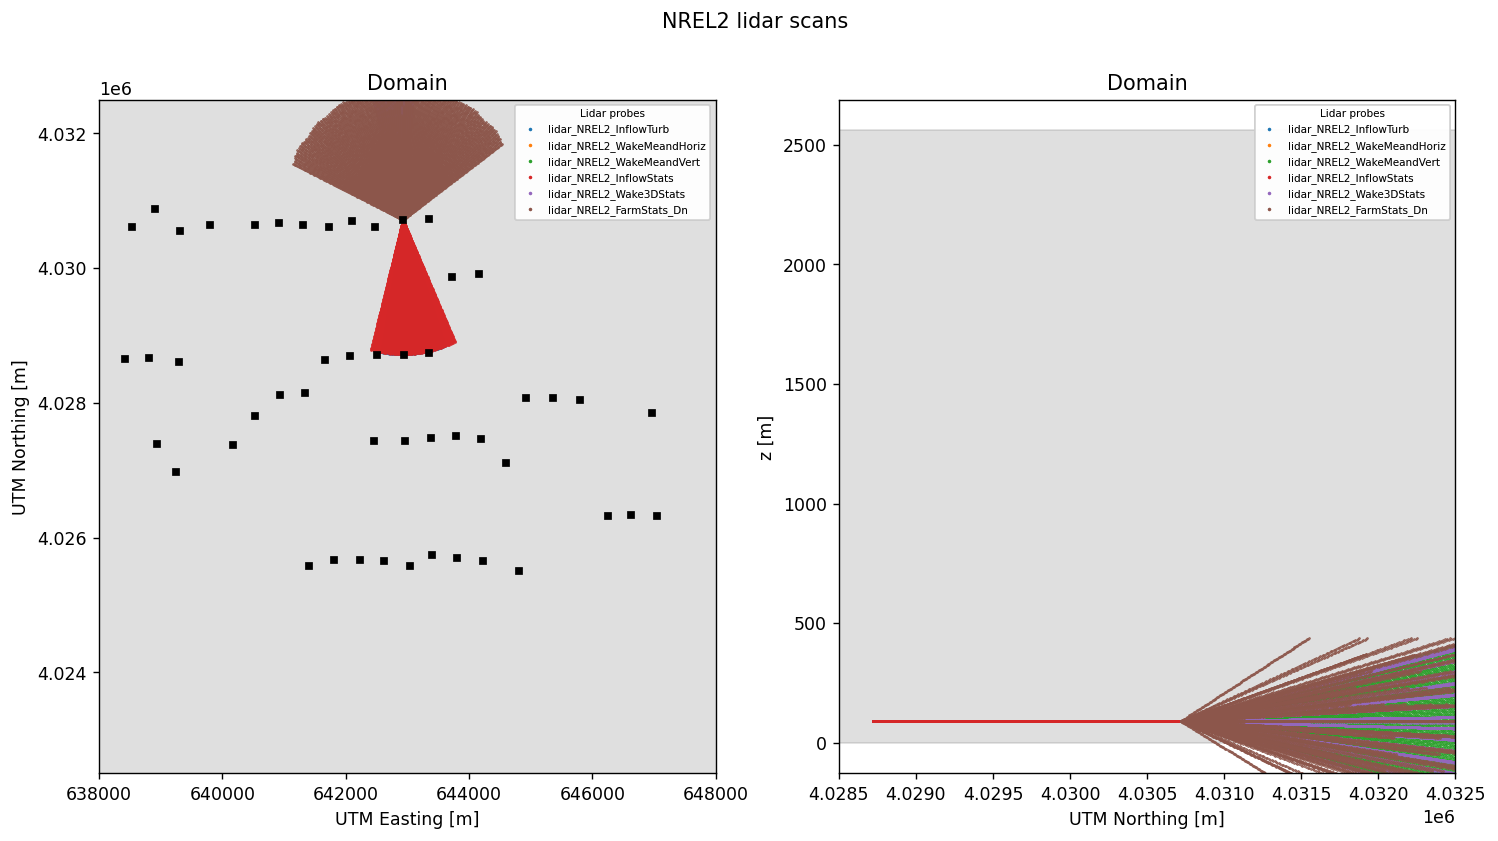

In [14]:
# Plot the domain
fig, axs = plt.subplots(1,2,figsize=(14,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':1, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Lidar probes', 'fontsize':6, 'loc':'upper right', 'markerscale':2}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['lidar_NREL2_InflowTurb',
                                                                'lidar_NREL2_WakeMeandHoriz',
                                                                'lidar_NREL2_WakeMeandVert',
                                                                'lidar_NREL2_InflowStats',
                                                                'lidar_NREL2_Wake3DStats',
                                                                'lidar_NREL2_FarmStats_Dn'
                                                               ] #case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY' #'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] 
case.popup_storteddata['plotdomain']['plot_turbines']        = [] #case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False

ax = axs[0]
case.plotDomain(ax=ax, verbose=False, plotskip=5)

# Plot the turbines on top of it
for x in KPturbdf.iterrows():    
    ax.plot(float(x[1][' x']), float(x[1][' y']), 'ks', markersize=4)

ax.set_aspect('auto')
ax.set_xlim([638000,  648000])
ax.set_ylim([4022500, 4032500])
ax.set_xlabel('UTM Easting [m]')
ax.set_ylabel('UTM Northing [m]')

# Plot the side view
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
ax = axs[1]
case.plotDomain(ax=ax, verbose=False, plotskip=5)
ax.set_aspect('auto')
ax.set_xlim([4028500, 4032500])
ax.set_xlabel('UTM Northing [m]')
fig.suptitle('NREL2 lidar scans')

Text(0.5, 0.98, 'EPFL2/3 lidar scans')

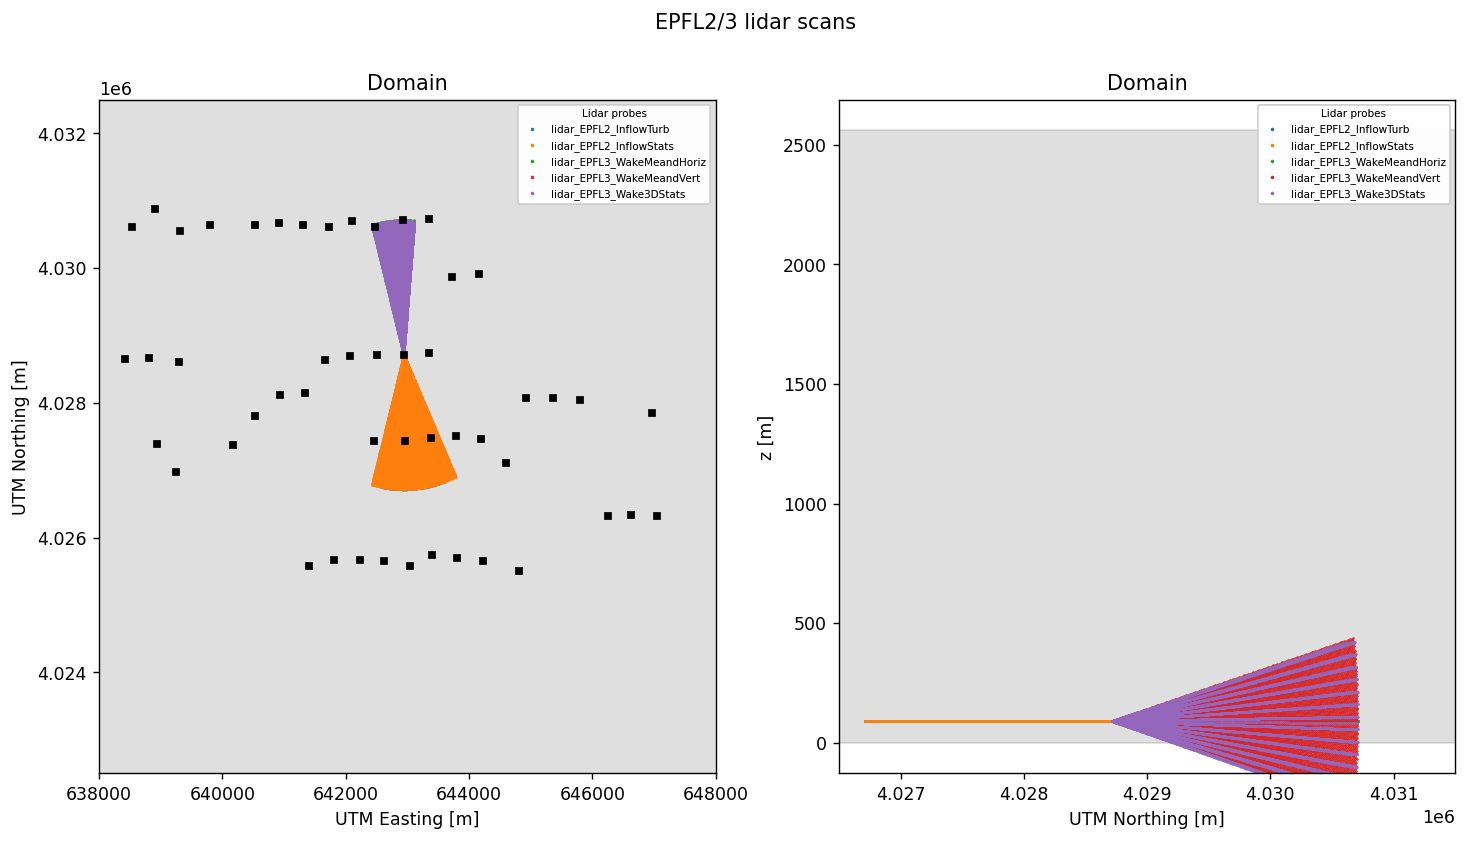

In [15]:
# Plot the domain
fig, axs = plt.subplots(1,2,figsize=(14,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':1, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Lidar probes', 'fontsize':6, 'loc':'upper right', 'markerscale':2}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['lidar_EPFL2_InflowTurb',
                                                                'lidar_EPFL2_InflowStats',
                                                                'lidar_EPFL3_WakeMeandHoriz',
                                                                'lidar_EPFL3_WakeMeandVert',
                                                                'lidar_EPFL3_Wake3DStats'
                                                               ] #case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY' #'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] 
case.popup_storteddata['plotdomain']['plot_turbines']        = [] #case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False

ax = axs[0]
case.plotDomain(ax=ax, verbose=False, plotskip=5)

# Plot the turbines on top of it
for x in KPturbdf.iterrows():    
    ax.plot(float(x[1][' x']), float(x[1][' y']), 'ks', markersize=4)

ax.set_aspect('auto')
ax.set_xlim([638000,  648000])
ax.set_ylim([4022500, 4032500])
ax.set_xlabel('UTM Easting [m]')
ax.set_ylabel('UTM Northing [m]')

# Plot the side view
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
ax = axs[1]
case.plotDomain(ax=ax, verbose=False, plotskip=5)
ax.set_aspect('auto')
ax.set_xlim([4026500, 4031500])
ax.set_xlabel('UTM Northing [m]')
fig.suptitle('EPFL2/3 lidar scans')

Text(0.5, 0.98, 'NREL Galileo lidar scans')

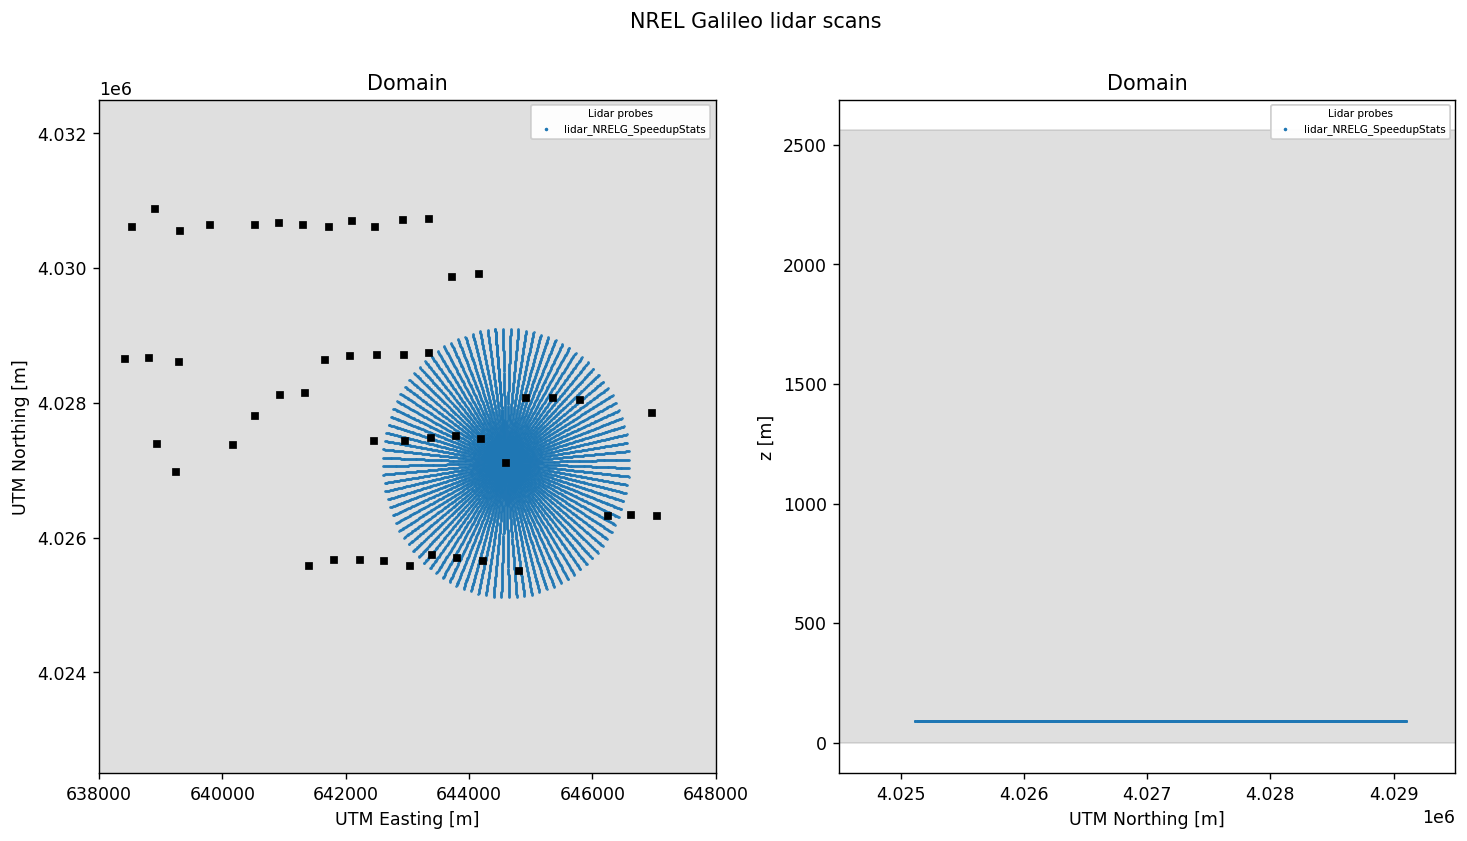

In [16]:
# Plot the domain
fig, axs = plt.subplots(1,2,figsize=(14,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':1, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Lidar probes', 'fontsize':6, 'loc':'upper right', 'markerscale':2}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['lidar_NRELG_SpeedupStats'
                                                               ] #case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY' #'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] 
case.popup_storteddata['plotdomain']['plot_turbines']        = [] #case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False

ax = axs[0]
case.plotDomain(ax=ax, verbose=False, plotskip=5)

# Plot the turbines on top of it
for x in KPturbdf.iterrows():    
    ax.plot(float(x[1][' x']), float(x[1][' y']), 'ks', markersize=4)

ax.set_aspect('auto')
ax.set_xlim([638000,  648000])
ax.set_ylim([4022500, 4032500])
ax.set_xlabel('UTM Easting [m]')
ax.set_ylabel('UTM Northing [m]')

# Plot the side view
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
ax = axs[1]
case.plotDomain(ax=ax, verbose=False, plotskip=5)
ax.set_aspect('auto')
ax.set_xlim([4024500, 4029500])
ax.set_xlabel('UTM Northing [m]')
fig.suptitle('NREL Galileo lidar scans')

In [17]:
print(case.writeAMRWindInput(''))

# --- Simulation time control parameters ---
time.stop_time                           = 100.0               # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = -1.0                # Fixed timestep size (in seconds). If negative, then time.cfl is used
incflo.verbose                           = 0                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
incflo.gravity                           = 0.0 0.0 -9.81       # Gravitational acceleration vector (x,y,z) [m/s^2]
incflo.density                           = 1.0                 # Fluid density [kg/m^3]
transport.viscosity                      = 1.872e-05           # Fluid dynamic viscosity [kg/m-s]
transport.laminar_prandtl                = 0.7                 # Laminar prandtl number
transport.tu